In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(rstatix)
library(ggh4x)
is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  }else{return('black')}
}
   


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [2]:

color_annotation <- read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read CXCR5 expression for Confirmation Cohorts(SF4)

In [3]:
df<-read.csv('01_Extract_Mean_Expression//CXCR5_CM_CD4T_SF4.csv')
df$celltype <- gsub("cell", "", df$celltype)

# Plotting

Warning message:
“There was 1 warning in `dplyr::summarise()`.
ℹ In argument: `p_value = cor.test(Ages, Mean_Expression, method =
  "spearman")$p.value`.
Caused by warning in `cor.test.default()`:
! Cannot compute exact p-value with ties”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


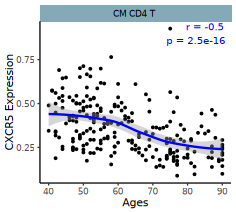

In [12]:
options(repr.plot.width = 50/25.4, repr.plot.height = 45/25.4)
correlation_tests <- df %>% #filter(Variable=='Core_Memory_B_TNFA_SIGNALING_VIA_NFKB_Pathway') %>%
  dplyr::summarise(
    correlation = cor(Ages, Mean_Expression, method = 'spearman'),
    p_value = cor.test(Ages, Mean_Expression, method = 'spearman')$p.value
  )
p <- ggplot(df, 
            aes(Ages, Mean_Expression)) +
    geom_point(size = 0.8, stroke = 0) +
    geom_smooth(se=TRUE, linewidth=0.5, color='blue') +
    theme_classic(base_size = 6)  +
    xlab('Ages') + 
    ylab('CXCR5 Expression')+theme(strip.background = element_rect(linewidth = 0))+
  geom_text(
    data = correlation_tests,
    aes(
      x = Inf, y = Inf,
      label = paste("r =", round(correlation, 2), "\np =", format.pval(p_value, digits = 3, eps = 0.0000000000000001)),
      hjust = 1.1, vjust = 1.1
    ),
    inherit.aes = FALSE,
    size = 2,
    color = "blue"
  )+
facet_wrap2(~celltype, axes = "all", remove_labels = "all", ncol=1, scale='free_y') 

g <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', g$layout$name))

pal <- color_vector['CM CD4 T cell']
text_color <- sapply(color_vector['CM CD4 T cell'], is_dark_color)

for (i in seq_along(strips)) {
  k <- which(grepl('rect', g$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', g$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  g$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <-  adjustcolor(pal[i], alpha.f = 0.8)
  g$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(g)
ggsave('FigureB.pdf',g,width = 45/25.4,height = 45/25.4)